In [1]:
import warnings
warnings.filterwarnings('ignore')

from os import path, makedirs
import re
import json
from typing import List, Union

import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
from TSB_UAD.models.distance import Fourier
from TSB_UAD.models.feature import Window
from TSB_UAD.utils.slidingWindows import find_length,plotFig, printResult
from sklearn.preprocessing import MinMaxScaler

from TSB_UAD.models.sand import SAND

<h1>Generate Dataset</h1>

In [2]:
base_path = "TSB-UAD-Public"

def read_dataset_as_df(filepath):
    df = pd.read_csv(filepath, header=None).dropna()
    df[0] = df[0].astype(float) # assuming univariate
    df[1] = df[1].astype(int)   # label
    return df

def generate_dataset(filepaths: List[str], sample_size: Union[int,float]=None):
    
    # Read
    filepaths = [path.join(base_path, fp) for fp in filepaths]
    normality = len(filepaths)
    datasets = [read_dataset_as_df(fp) for fp in filepaths]
    
    # Sampling
    if sample_size is not None:
        if sample_size <= 1:  # sample size was defined as a percentage of the original series' size
            sample_size = [int(dataset.shape[0] * sample_size) for dataset in datasets]
        else: # sample size was defined as maximun number of points
            sample_size = [min(dataset.shape[0], sample_size) for dataset in datasets]
            
        for i, (dataset_sample_size, dataset) in enumerate(zip(sample_size, datasets)):
            datasets[i] = dataset[:dataset_sample_size]
    
    # Concatenate
    shift_idxs = []
    if len(datasets) > 1:
        cumulative_length = 0
        for i, dataset in enumerate(datasets[:-1]):
            cumulative_length += len(dataset)
            shift_idxs.append(cumulative_length)
            
    # Concatenate the list of DataFrames along rows (axis=0)
    merged_dataset = pd.concat(datasets, ignore_index=True)
    return merged_dataset, normality, shift_idxs



In [3]:

def _plot_generated_dataset(df: pd.DataFrame,
                           x_values,
                           shift_idxs=None):
    
    y_values = df[0].values         # First column ('0') values as y-values
    color_values = df[1].values     # Second column ('1') values for coloring (0 or 1)

    # Plotting the time series with conditional coloring
    plt.figure(figsize=(12,4))  # Set the figure size (width, height)

    # Plot the entire time series as a line plot
    plt.plot(x_values, y_values, color='black', linewidth=2)

    # Initialize segment start index and color
    segment_start = 0
    current_color = color_values[0]

    # Iterate over data points to plot line segments with different colors
    for i in range(1, len(df)):
        if color_values[i] != current_color:
            # Plot the previous segment with the current color
            plt.plot(x_values[segment_start:i], y_values[segment_start:i], color='red' if current_color == 1 else 'black', linewidth=2)
            # Update segment start index and current color
            segment_start = i
            current_color = color_values[i]

    # Plot the last segment
    plt.plot(x_values[segment_start:], y_values[segment_start:], color='red' if current_color == 1 else 'black', linewidth=2)
    
    for shift_idx in shift_idxs:
        plt.axvline(shift_idx, color='blue', linestyle='--', linewidth=1.5)

    # Display the plot
    plt.show()

def plot_generated_dataset(df: pd.DataFrame, 
                           plot_around_distro_shifts=False, 
                           plot_range=1000,
                           shift_idxs: List[int]=None):
    
    # Extract values from DataFrame
    if plot_around_distro_shifts and shift_idxs is not None and len(shift_idxs) > 0:
        for shift_idx in shift_idxs:  # different plot for each distro shift
            x_values = np.arange(shift_idx - plot_range, shift_idx + plot_range + 1)
            df_partial = df.loc[x_values]
            _plot_generated_dataset(df_partial, x_values, [shift_idx])
    
    else:
        x_values = np.arange(len(df))  # Use numerical index as x-values
        _plot_generated_dataset(df, x_values, shift_idxs)


Series len = 100000
Normality = 1
Distro shift indexes = []


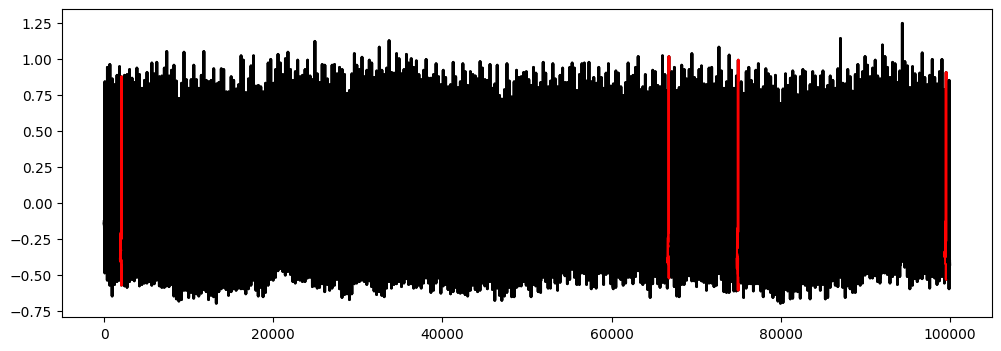

In [4]:
dataset1_path = 'ECG/MBA_ECG801_data.out'
dataset2_path = 'MITDB/100.test.csv@1.out'
filepaths = [dataset2_path]
df, normality, shift_idxs = generate_dataset(filepaths, sample_size=100000)

print(f"Series len = {df.shape[0]}\nNormality = {normality}\nDistro shift indexes = {shift_idxs}")
plot_generated_dataset(df, plot_around_distro_shifts=True, plot_range=5000, shift_idxs=shift_idxs)


<h1>Evaluation Metrics / Save Results</h1>

In [5]:

output_path_base = "results"

def save_dict_to_json_file(dictionary, filename):
    makedirs(path.dirname(filename), exist_ok=True)
    
    with open(filename, 'w', encoding='utf-8') as json_file:
        json.dump(dictionary, json_file, indent=4, ensure_ascii=False)


def gather_results(model_name, online, label, score, slidingWindow, datasets_names, normality, save_to_json=True):
    
    datasets_names_norm = "_".join(datasets_names)
    datasets_names_norm = re.sub(r'[^A-Za-z0-9]', '.', datasets_names_norm)
    output_json = path.join(output_path_base, f"normality_{normality}", f"{datasets_names_norm}_{model_name}_{'online' if online else 'offline'}.json")
    
    results = printResult(None, label, score, slidingWindow, None, None)
    results = [float(value) for value in results]
    results = {
        "model": model_name,
        "online": online,
        "normality": normality,
        "datasets": datasets_names,
        "series_length": len(label),
        "window": int(slidingWindow),
        "AUC": results[0],
        "Precision": results[1],
        "Recall": results[2],
        "F": results[3],
        "Precision@k": results[9],
        "Rprecision": results[7],
        "Rrecall": results[4],
        "Rf": results[8],
        "ExistenceReward": results[5],
        "OverlapReward": results[6],
        "RAUC": results[10]
    }
    save_dict_to_json_file(results, output_json)
    return results


<h1>Test SAND method</h1>

In [53]:
data = df[0]
label = df[1]
slidingWindow = find_length(data)

print("Estimated Subsequence length: ",slidingWindow)
print("Time series length: ",len(data))
print("Number of abnormal points: ",list(label).count(1))


Estimated Subsequence length:  285
Time series length:  100000
Number of abnormal points:  1397


0-->5000-->10000-->15000-->20000-->25000-->30000-->35000-->40000-->45000-->50000-->55000-->60000-->65000-->70000-->75000-->80000-->85000-->90000-->95000-->[STOP]: score length 100000


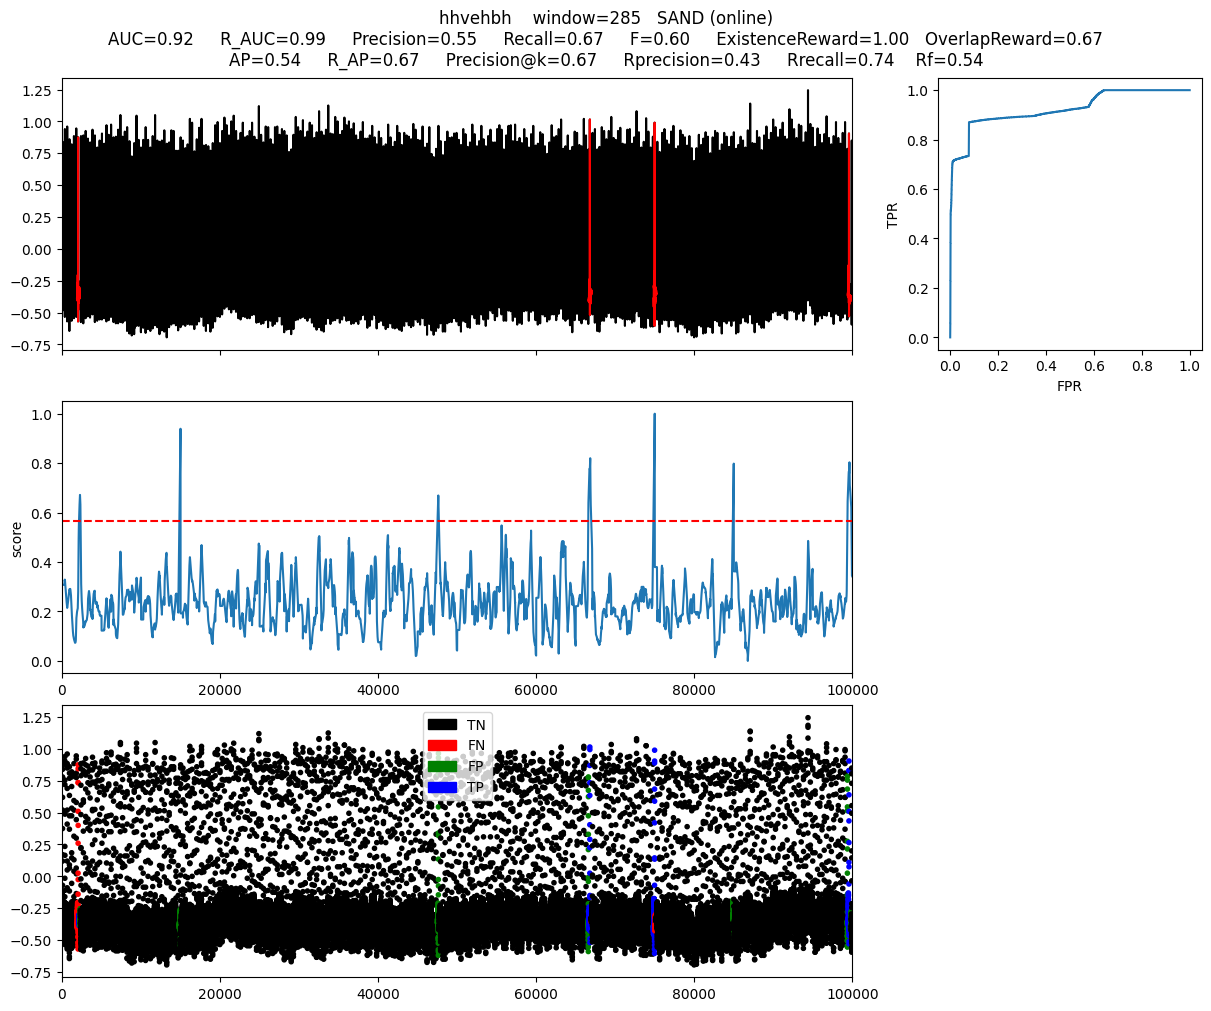

In [17]:
name = "hhvehbh"
modelName='SAND (online)'
clf = SAND(pattern_length = slidingWindow, subsequence_length = 4*(slidingWindow))
x = data
clf.fit(x, online=True, alpha=0.5, init_length=5000, batch_size=5000, verbose=True, overlaping_rate=int(4*slidingWindow))
score = clf.decision_scores_
score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()
plotFig(data, label, score, slidingWindow, fileName=name, modelName=modelName)


In [29]:
gather_results(modelName, True, label, score, slidingWindow, filepaths, normality)

{'model': 'SAND (online)',
 'online': True,
 'normality': 1,
 'datasets': ['MITDB/100.test.csv@1.out'],
 'series_length': 100000,
 'window': 285,
 'AUC': 0.9244663336938723,
 'Precision': 0.5512744516893895,
 'Recall': 0.6657122405153901,
 'F': 0.6031128404669261,
 'Precision@k': 0.6657122405153901,
 'Rprecision': 0.4296106945613082,
 'Rrecall': 0.7354164137377648,
 'Rf': 0.542378377373451,
 'ExistenceReward': 1.0,
 'OverlapReward': 0.669270517172206,
 'RAUC': 0.9852275785161532}

<h1>Test EncDec-AD </h1>
<h3>LSTM Autoencoder (offline)</h3>

In [6]:
import os, sys
sys.path.append(os.getcwd())
sys.path.append(path.join(os.getcwd(), "EncDec-AD"))
from lstm_enc_dec_axl import LSTMED
from torch.cuda import is_available, current_device
from sklearn.metrics import roc_auc_score, fbeta_score

In [7]:
def separate_sets(X, Y, train_perc=0.1, val_perc=0.0):
    train_idx = int(train_perc * len(X))
    X_train, Y_train = X[:train_idx].reset_index(drop=True), Y[:train_idx].reset_index(drop=True)
    
    if val_perc > 0.0:
        val_idx = int(val_perc * len(X))
        X_val, Y_val = X[train_idx:train_idx + val_idx].reset_index(drop=True), Y[train_idx:train_idx + val_idx].reset_index(drop=True)
    else:
        X_val, Y_val = None, None
    
    test_idx = train_idx + (val_idx if val_perc > 0.0 else 0)
    X_test, Y_test = X[test_idx:].reset_index(drop=True), Y[test_idx:].reset_index(drop=True)

    return X_train, Y_train, X_val, Y_val, X_test, Y_test


Device = 0


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [07:48<00:00, 23.41s/it]


Training finished
0.5540417992821015


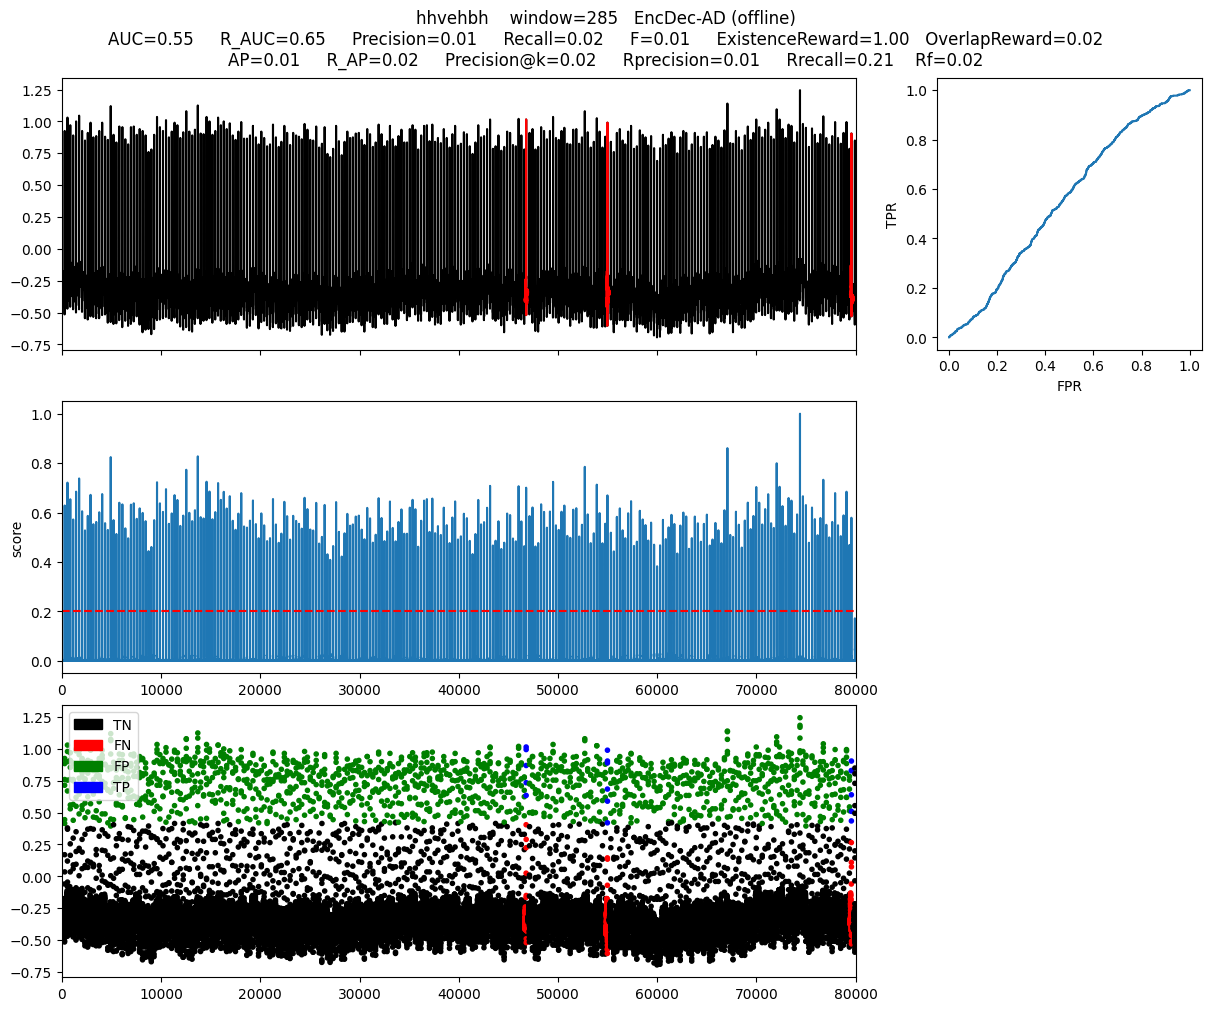

In [10]:
name = "hhvehbh"
modelName = "EncDec-AD (offline)"
device = current_device() if is_available() else None
print(f"Device = {device}")

X = df[[0]]
Y = df[1]
slidingWindow = find_length(X[0])
X_train, Y_train, X_val, Y_val, X_test, Y_test = separate_sets(X, Y, train_perc=0.2, val_perc=0)

# train
batch_size = int((slidingWindow // 100) * 100 + 100)
enc_dec_ad = LSTMED(num_epochs=20, batch_size=batch_size, hidden_size=40, sequence_length=slidingWindow, seed=42, gpu=device)
enc_dec_ad.fit(X_train)
print("Training finished")

# test
score = enc_dec_ad.predict(X_test)
print(roc_auc_score(Y_test, score))

# show evaluation results
score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()
plotFig(X_test[0], Y_test, score, slidingWindow, fileName=name, modelName=modelName)
